<h2 style="text-align: center;">Cox model and Feature Importancy</h2>

This notebook preprocesses data, including imputing and creating a cox model for the training dataset or implementing an existing model for the test dataset.

### Choose name and data type in section 'User input'

### Results are available in the section 'Results':
- **Cox model C-index score**
- **Feature importance plot**
- **Kaplan-Meier plot**
  - Here, you can choose what features should be presented on the plot.

### Used Functions and Procedures from `/models/`:
- Preprocess data steps:
  1. Read dataframe and Create directory in `data_information/` to save data information
  2. Extract features datatype and create datatype lists from `index_list_num_cat_ord_bin.csv`

  3. Data correction:
      1. `Nein` to `Nan` for ['dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam']
      2. Convert numerical features type to float (original type: object)
      3. Correction for 'kofscore':  20.21 to Nan
      4. ECOG value 9.0 to Nan, bin category 0,1 - 0; 2,3,4 - 1
      5. `dx_sex` to `dx_female_sex` 1/0,  bin category
      6. Find outliers. Change for outliers 99-type input to Nan 
      7. BMI  
          1. Find BMI and using possible BMI interval estimate the swap weight and height columns
          2. BMI for dx, l1, l2 instead of height and weight features
          3. Calculate relative BMI change: `l1_BMI_change`, `l2_BMI_change`

      8. Data type columns:
          1. Calculate duration of rtx
          2. Calculate relative age when patient was diagnosed
          3. Drop data `ddmmyy` type columns

  4. Data mapping:
      1. Replace 'Ja'/ 'Nein'/ 'Nicht getestet' to 1/ 0/ NaN (99) numerical value
      2. Mapping object type data:
          1. Sorting by number in the line:
              Example: 
              '<3,5 mg/L': 1, '3,5 - 5,5 mg/L': 2, '>5,5 mg/L': 3
          2. Sorting by Stadium I, II, III: giving indexes of mapping 1, 2, 3
          3. For Unbekant Stadium: index 0

  5. Dropping Features
        
      'training':

          1. One unique value in column - 54 features was dropped
          2. Imbalance feature drop and categories combination with small statistic (< 6%) -> Create list of combined categories per each feature
              - Save data about categories combination to `/dictionaries/replaced_values.json`
          3. Drop all repeated/ duplicate information/ high correlated values:
              - drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height', 'l1_BMI','l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg']
              - Drop 'l1_protg' due to high correlation with 'l2_protg'
          4. Drop outliers for ['dx_protg', 'l1_protg', 'l2_protg'] 

          after all steps, remain features list is saved in `/dictionaries/features_list_to_keep.json`
        
      'test':    

          1. Open:
          `/dictionaries/replaced_values.json`
              - to combine categories inside each feature the same way as was done for training dataset 
          `/dictionaries/features_list_to_keep.json`
              - to drop all features the same way as for training dataset
              -if some column is missing, make a warning to retrain dataset

          2. Remove outliers

  6. Preprocess data
      - 'test'
        `preprocess_test_data(df_load, additional_name='')`
          - to apply the same transformation that was learned from the training data
        
      - 'training'
        
        `preprocess_data(df_load, threshold_feature_drop=27, directory_name='models', additional_name='')`
          - drop features with high missing values: threshold_feature_drop=27
          - fixed imputers for different features categories:
              cat_imputer = SimpleImputer(strategy='most_frequent')
              num_imputer = KNNImputer(n_neighbors=10)
              cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 
              scaler = QuantileTransformer()
          - split the data into training and testing sets
          - return:
              X_train = preprocessor.fit_transform(X_train) # model can learn the parameters of the transformations from this data
              X_test= preprocessor.transform(X_test) #to apply the same transformation that was learned from the training data

        `preprocess_data_choose_imputer(df_load, threshold_feature_drop=25, directory_name='models', additional_name='', cat_imputer=SimpleImputer(strategy='most_frequent'), num_imputer=KNNImputer(n_neighbors=10), scaler=QuantileTransformer())`
          - function to choose imputers for each feature categories
          - choose parameters values: 
              categorical and binomial (yes/no) feature imputer:
                  cat_imputer=SimpleImputer(strategy='most_frequent'), 
              numerical feature imputer and numerical data scaler:
                  num_imputer=KNNImputer(n_neighbors=10), 
                  scaler=QuantileTransformer()

          - split the data into training (80%) and testing (20%) sets
          - return:
              X_train = preprocessor.fit_transform(X_train) # model can learn the parameters of the transformations from this data
              X_test= preprocessor.transform(X_test) #to apply the same transformation that was learned from the training data

- Cox Model, feature importance, and Kaplan-Meier plot steps:
    1. `datatype_extraction_procedure(df, path_list="dictionaries/", report = 0)`
       procedure that returns back the lists of different types of variables from the dataset

    2. `cox_model(X_train, X_test, data_type = 'training', penalizer=0.0001, l1_ratio=0.9)`
       General Cox model

    3. `cox_feature_importancy(X_train, X_test, clean_feature = True, data_type = 'training', feature_excluded_from_plot =[], size = (30,40), directory_name='', penalizer=0.0001, l1_ratio=0.9, additional_name='' )`
       Cox model with feature importance plot.
       This function allows creating the cox model with/without Lasso less significant features clean-up method and build the plot of important features 

    4. `Kaplan_Meier_plot(X_train, lim_min_percent=10, feature_groups_specific=[], plot_name='', directory_name='')`
       Kaplan Meier curves for balanced categories

    5. `color_style()`
       color and style of plots


In [64]:
#import all modules to the project to use functions

import sys
from pathlib import Path

# This should point to the project root where 'modules' directory is located
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# importing modules
from modules import *


In [65]:
import numpy as np
import pandas as pd
import re
import os
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer, Normalizer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


Set_up_option

<function modules.display_set_up.Set_up_option()>

# 1.0 User input  
### Choose information about dataset

In [ ]:
#Choose 1/0 train/test data type
data_type_train = 1  #1 - train,  0 - test

In [66]:
#Correct data_name in case of the different data type names

#it choose data type: data_frame_type = training or test  
#it choose data file name: data_name

if data_type_train ==1:
    #training data
    data_name = 'training_df'  
    data_frame_type = 'training' 

elif data_type_train ==0:
    #test data
    data_name = 'test_df'
    data_frame_type = 'test'

******************************************************** Automatical section *****************************************************************************
# 2. Data preprocessing

### 2.1 read data file:

In [67]:

df = read_df(data_name)

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


### 2.2 Create directory to save information about data

In [68]:
#def create_directory_main(data_name, parent_directory = "intermediate_report")
directory_name = create_directory_main(data_name, parent_directory = "intermediate_report")

Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-11_training_df exist
Directory ../intermediate_report/24-03-11_training_df/figures exist


### 2.3 Correct data
1. Convert "Nein" to `NaN` for the following columns:
   - `['dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam']`
2. Convert numerical features type to float (original type: object).
3. Correction for `'kofscore'`: replace `20.21` with `NaN`.
4. ECOG value `9.0` to `NaN`, bin category `0,1` - `0`; `2,3,4` - `1`.
5. Convert `dx_sex` to `dx_female_sex` `1/0`, bin category.
6. Find outliers. Change for outliers `99`-type input to `NaN`.
7. BMI:
    1. Find BMI and using possible BMI interval estimate the swap weight and height columns.
    2. Implement BMI for `dx`, `l1`, `l2` instead of height and weight features.
    3. Calculate relative BMI change: `l1_BMI_change`, `l2_BMI_change`.
8. Data type columns:
    1. Calculate duration of rtx.
    2. Calculate relative age when the patient was diagnosed.
    3. Drop data `ddmmyy` type columns.


In [69]:
df = data_correction(df)

Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam', 'l1_supperythnr', 'l2_supperythnr', 'l1_TTNT', 'l2_TTNT']
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat        object
l1_lightrat        object
l2_lightrat        object
dx_lightkap        object
l1_lightkap        object
l2_lightkap        object
dx_lightlam        object
l1_lightlam        object
l2_lightlam        object
l1_supperythnr    float64
l2_supperythnr    flo

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

2. calculate relative age when patient was diagnosed
dx_iddat_age column was added to dataframe
l1_opdat_age column was added to dataframe
l2_opdat_age column was added to dataframe
3. Drop data ddmmyy-type columns
END: DDMMYY_type_correction 



### 2.4 Save information about amount of missing and unique values for each feature

In [70]:
df_missing_count(df,directory_name)



../intermediate_report/24-03-11_training_df/raw_unique_values_and_missing_count.csv was created


### 2.5 Data Mapping

1. Replace categorical values with numerical values:
   - Convert `'Ja'`/ `'Nein'`/ `'Nicht getestet'` to `1`/ `0`/ `NaN` (for `99`) respectively.
   
2. Mapping object type data:
   1. Sorting by number in the line:
      - Example: 
        - `'<3,5 mg/L'`: 1
        - `'3,5 - 5,5 mg/L'`: 2
        - `'>5,5 mg/L'`: 3
   2. Sorting by Stadium:
      - Assign indexes based on stadium number:
        - `Stadium I`: 1
        - `Stadium II`: 2
        - `Stadium III`: 3
   3. For `Unbekannt Stadium` (Unknown Stadium):
      - Assign index 0.


In [71]:
df_02_mapping, value_mapping = data_mapping(df, directory_name, data_name)

List_ordinary_values:
['dx_dusa', 'l1_dusa', 'dx_iss', 'l1_iss', 'l2_iss', 'dx_riss', 'l1_riss', 'l2_riss', 'dx_mikroserlevel', 'l1_mikroserlevel', 'l2_mikroserlevel', 'dx_klonzell', 'l1_klonzell', 'l2_klonzell']


In [72]:
df_02_mapping.head()

,l2_rtptheraentsch,l2_rtpremdauer,l2_rtpnotwmprot,l2_rtpnotwosteo,l2_rtpnotwpathfrak,l2_rtpnotwinsuffi,l2_rtpnotwhyperkalz,l2_rtpnotwledh,l2_rtpnotwnierenin,l2_rtpnotwande,...,dx_BMI,l1_BMI,l2_BMI,l1_BMI_change,l2_BMI_change,l1_rtxdauer,l2_rtxdauer,dx_iddat_age,l1_opdat_age,l2_opdat_age
0,1.0,3.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,0.0,...,22.222222,22.222222,22.222222,0.0,0.00,NaN,NaN,70.0,NaN,NaN
1,1.0,3.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,21.887076,21.887076,20.177149,0.0,0.08,NaN,NaN,70.0,NaN,NaN
2,1.0,3.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,...,19.753086,19.753086,19.753086,0.0,0.00,NaN,NaN,51.0,NaN,NaN
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,22.031726,22.031726,22.031726,0.0,0.00,NaN,NaN,82.0,NaN,NaN
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,0.0,0.0,...,23.510204,23.510204,23.510204,0.0,0.00,NaN,NaN,69.0,NaN,NaN


output mapping for values for each features:

In [73]:
value_mapping

{'l2_rtptheraentsch': {'Rezidiv ICD C90.01': 1,
  'Refraktärer Patient': 2,
  'Anderer Grund': 3,
  nan: nan},
 'l2_rtpremdauer': {'Bis zu 6 Monate': 1,
  '7-12 Monate': 2,
  'Länger als 12 Monate': 3,
  nan: nan},
 'l2_rtpplasmo': {0: 0,
  nan: nan,
  'Knochen-unabhängig': 1,
  'Knochen-abhängig': 2},
 'dx_versi': {'Gesetzlich': 1, 'Privat': 2, nan: nan, 'Andere': 3},
 'dx_fit': {nan: nan,
  'Eingeschränkte Fitness': 2,
  'Fitter Patient': 1,
  'Unfitter Patient': 3},
 'l1_fit': {'Unfitter Patient': 3,
  'Fitter Patient': 1,
  'Eingeschränkte Fitness': 2,
  nan: nan},
 'l2_fit': {'Eingeschränkte Fitness': 2,
  'Fitter Patient': 1,
  'Unfitter Patient': 3,
  nan: nan},
 'dx_mmtyp': {'ICD-10 C90.0 Multiples Myelom (symptomatisch)': 1,
  'ICD-10 D47.2 MGUS - monoklonale Gammopathie unklarer Signifikanz': 2,
  'ICD-10 C90.0 Smouldering Myeloma (asymptomatisch)': 3,
  'ICD-10 C90.1 Plasmazell-Leukämie': 4,
  'ICD-10 C90.3 Solitäres Plasmozytom': 5,
  nan: nan},
 'l1_mgussmmm': {nan: nan, '

### 2.6 Drop features

**'training':**

1. **One unique value in column:**
   - 54 features were dropped due to having only one unique value.
   
2. **Imbalance feature drop and categories combination with small statistics (< 6%): combine_categories=True**
   - Create a list of combined categories per each feature.
   - Save data about categories combination to `'helper/data_dictionary/replaced_values.json'`.
   
3. **Drop all repeated/duplicate information/high correlated values:**
   - `drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height', 'l1_BMI','l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg']`
   - Drop `'l1_protg'` due to high correlation with `'l2_protg'`.
   
4. **Drop outliers for `['dx_protg', 'l1_protg', 'l2_protg']`.**

   - After all steps, the remaining features list is saved in `'helper/data_dictionary/features_list_to_keep.json'`.

**'test':**

1. **Open:**
   - `'helper/data_dictionary/replaced_values.json'` to combine categories inside each feature the same way as was done for the training dataset.
   - `'helper/data_dictionary/features_list_to_keep.json'` to drop all features the same way as for the training dataset. If some column is missing, make a warning to retrain the dataset.

2. **Remove outliers.**


In [74]:
#def drop_features(df,min_percent = 0.06, data_type ='train', combine_categories=True, data_name='', directory_name='', drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height',	'l1_BMI'	,'l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg']):
df_02_mapping_drop =  drop_features(df_02_mapping,min_percent = 0.06, data_type =data_frame_type, combine_categories=True, data_name=data_name, directory_name=directory_name, drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height',	'l1_BMI'	,'l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg'])
 

Current Size: (2600, 392)
Drop one value features: 
54 columns were dropped. 
New Size: (2600, 338)
Imbalance features combination:
Current Size: (2600, 338)
Remove outliers for ['dx_protg', 'l1_protg', 'l2_protg']
Column 'l1_protg' not found in DataFrame.


In [75]:
df_02_mapping_drop.shape

(2600, 211)

### 2.7 Check unique sets of drugs. 
Could be used to combine drugs by sets in the analysis

In [76]:
l_list = ['l2_', 'l1_']

for l_element in l_list:
    print(f'l_element: {l_element}')

    columns_containing_drug = [column for column in df_02_mapping_drop.columns if 'drug' in column.lower()]
    df_02_mapping_drugs = df_02_mapping_drop[columns_containing_drug]
    l_columns = [col for col in df_02_mapping_drugs.columns if col.startswith(l_element)]

    # Initialize a list to hold the results for each row
    results = []

    # Iterate over each row in the DataFrame
    for index, row in df_02_mapping.iterrows():
        # Initialize a temporary list A for this row
        A = []
        
        # Check each 'l_' column in this row
        for col in l_columns:
            if row[col] == 1:
                A.append(col)
        
        # Add the list A to the results (one list per row)
        results.append(A)

    # Count the occurrences of each unique subset
    unique_subset_counts = {}
    for sublist in results:
    # Sort and convert to tuple for dictionary key
        sublist_tuple = tuple(sorted(sublist))
        if sublist_tuple in unique_subset_counts:
            unique_subset_counts[sublist_tuple] += 1
        else:
            unique_subset_counts[sublist_tuple] = 1

    # Sort the subsets based on their counts
    sorted_subsets = sorted(unique_subset_counts.items(), key=lambda x: x[1], reverse=True)

    # Print the sorted subsets with their counts
    for subset, count in sorted_subsets:
        print(f"Subset: {list(subset)}, Count: {count}")

    print(f'Number of unique subsets: {len(unique_subset_counts)}')


l_element: l2_
Subset: ['l2_drug_3', 'l2_drug_6'], Count: 916
Subset: ['l2_drug_3', 'l2_drug_4', 'l2_drug_6'], Count: 338
Subset: ['l2_drug_3', 'l2_drug_5', 'l2_drug_6'], Count: 316
Subset: ['l2_drug_3', 'l2_drug_5'], Count: 292
Subset: ['l2_drug_1', 'l2_drug_3'], Count: 278
Subset: ['l2_drug_1', 'l2_drug_3', 'l2_drug_4'], Count: 134
Subset: [], Count: 82
Subset: ['l2_drug_1'], Count: 76
Subset: ['l2_drug_4'], Count: 53
Subset: ['l2_drug_6'], Count: 26
Subset: ['l2_drug_1', 'l2_drug_3', 'l2_drug_6'], Count: 25
Subset: ['l2_drug_3'], Count: 22
Subset: ['l2_drug_3', 'l2_drug_4', 'l2_drug_5'], Count: 15
Subset: ['l2_drug_3', 'l2_drug_4'], Count: 6
Subset: ['l2_drug_1', 'l2_drug_4'], Count: 5
Subset: ['l2_drug_1', 'l2_drug_3', 'l2_drug_5'], Count: 3
Subset: ['l2_drug_4', 'l2_drug_6'], Count: 3
Subset: ['l2_drug_1', 'l2_drug_6'], Count: 2
Subset: ['l2_drug_1', 'l2_drug_3', 'l2_drug_5', 'l2_drug_6'], Count: 2
Subset: ['l2_drug_1', 'l2_drug_3', 'l2_drug_4', 'l2_drug_6'], Count: 2
Subset: ['l2

In [77]:
''' #code in process to combine subsets
#test
l_element=[['l2_drug_1', 'l2_drug_3'], ['l2_drug_3', 'l2_drug_6'], ['l2_drug_3', 'l2_drug_6'],['l2_drug_1', 'l2_drug_3', 'l2_drug_3', 'l2_drug_6'], ['l2_drug_3', 'l2_drug_6']]
set_list = [set(sublist) for sublist in l_element]
combined_subsets = set()
for i, subset_i in enumerate(set_list):
    for j, subset_j in enumerate(set_list):
        if i != j and subset_i.issubset(subset_j):
            combined_subsets.add(tuple(l_element[i]))

# Convert the set of tuples back to a list of lists
combined_subsets = [list(subset) for subset in combined_subsets]

combined_subsets'''

" #code in process to combine subsets\n#test\nl_element=[['l2_drug_1', 'l2_drug_3'], ['l2_drug_3', 'l2_drug_6'], ['l2_drug_3', 'l2_drug_6'],['l2_drug_1', 'l2_drug_3', 'l2_drug_3', 'l2_drug_6'], ['l2_drug_3', 'l2_drug_6']]\nset_list = [set(sublist) for sublist in l_element]\ncombined_subsets = set()\nfor i, subset_i in enumerate(set_list):\n    for j, subset_j in enumerate(set_list):\n        if i != j and subset_i.issubset(subset_j):\n            combined_subsets.add(tuple(l_element[i]))\n\n# Convert the set of tuples back to a list of lists\ncombined_subsets = [list(subset) for subset in combined_subsets]\n\ncombined_subsets"

# 3. RESULTS

### 3.1 Data Preprocess , Feature importancy plot 

['cat__l2_rtptheraentsch_1.0', 'cat__l2_rtptheraentsch_2.0', 'cat__l2_rtptheraentsch_3.0', 'cat__dx_versi_1.0', 'cat__dx_versi_2.0', 'cat__dx_versi_3.0', 'cat__dx_mmtyp_1.0', 'cat__dx_mmtyp_10.0', 'cat__dx_prottyp_1.0', 'cat__dx_prottyp_10.0', 'cat__l1_prottyp_10.0', 'cat__l2_prottyp_2.0', 'cat__l2_prottyp_10.0', 'cat__dx_einrverd_2.0', 'cat__dx_einrverd_3.0', 'cat__dx_einrverd_4.0', 'cat__dx_einrverd_5.0', 'cat__dx_fachverd_1.0', 'cat__dx_fachverd_3.0', 'cat__dx_fachverd_4.0', 'cat__dx_fachverd_10.0', 'cat__dx_einrid_2.0', 'cat__dx_einrid_10.0', 'cat__dx_fachid_1.0', 'cat__dx_fachid_3.0', 'cat__l2_rtpremdauer_2.0', 'cat__l1_fit_1.0', 'cat__l1_fit_3.0', 'cat__l2_fit_1.0', 'cat__l2_fit_3.0', 'cat__dx_dusa_1.0', 'cat__l1_dusa_1.0', 'cat__l1_dusa_3.0', 'cat__dx_iss_2.0', 'cat__dx_iss_3.0', 'cat__l1_iss_1.0', 'cat__l1_iss_2.0', 'cat__l2_iss_2.0', 'cat__l2_iss_3.0', 'bin__l2_rtpnotwmprot', 'bin__l2_rtpnotwosteo', 'bin__l2_rtpnotwinsuffi', 'bin__dx_female_sex', 'bin__l1_beglhyper', 'bin__l2_

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


             covariate                                  feature_name
0       bin__l1_drug_6                                   Drug 6 (l1)
1       bin__l1_drug_1                                   Drug 1 (l1)
2       bin__l1_drug_7                                   Drug 7 (l1)
3      bin__l2_ecogbin                                     ECOG (l2)
4         num__l1_TTNT                                     TTNT (l1)
5   num__l2_BMI_change                               BMI change (l2)
6    bin__l1_crabkritc                           Hypercalcaemia (l1)
7    bin__l2_suppdurch                       Supportive therapy (l2)
8      cat__l1_iss_3.0                          ISS Stadium III (l1)
9          num__dx_BMI                                           BMI
10  cat__dx_einrid_1.0        University Clinic (initial diagnostic)
11      bin__l2_drug_5                                   Drug 5 (l2)
12     bin__l1_smdurch  Chemotherapy for stem cell mobilisation (l1)
13      bin__l2_drug_4            

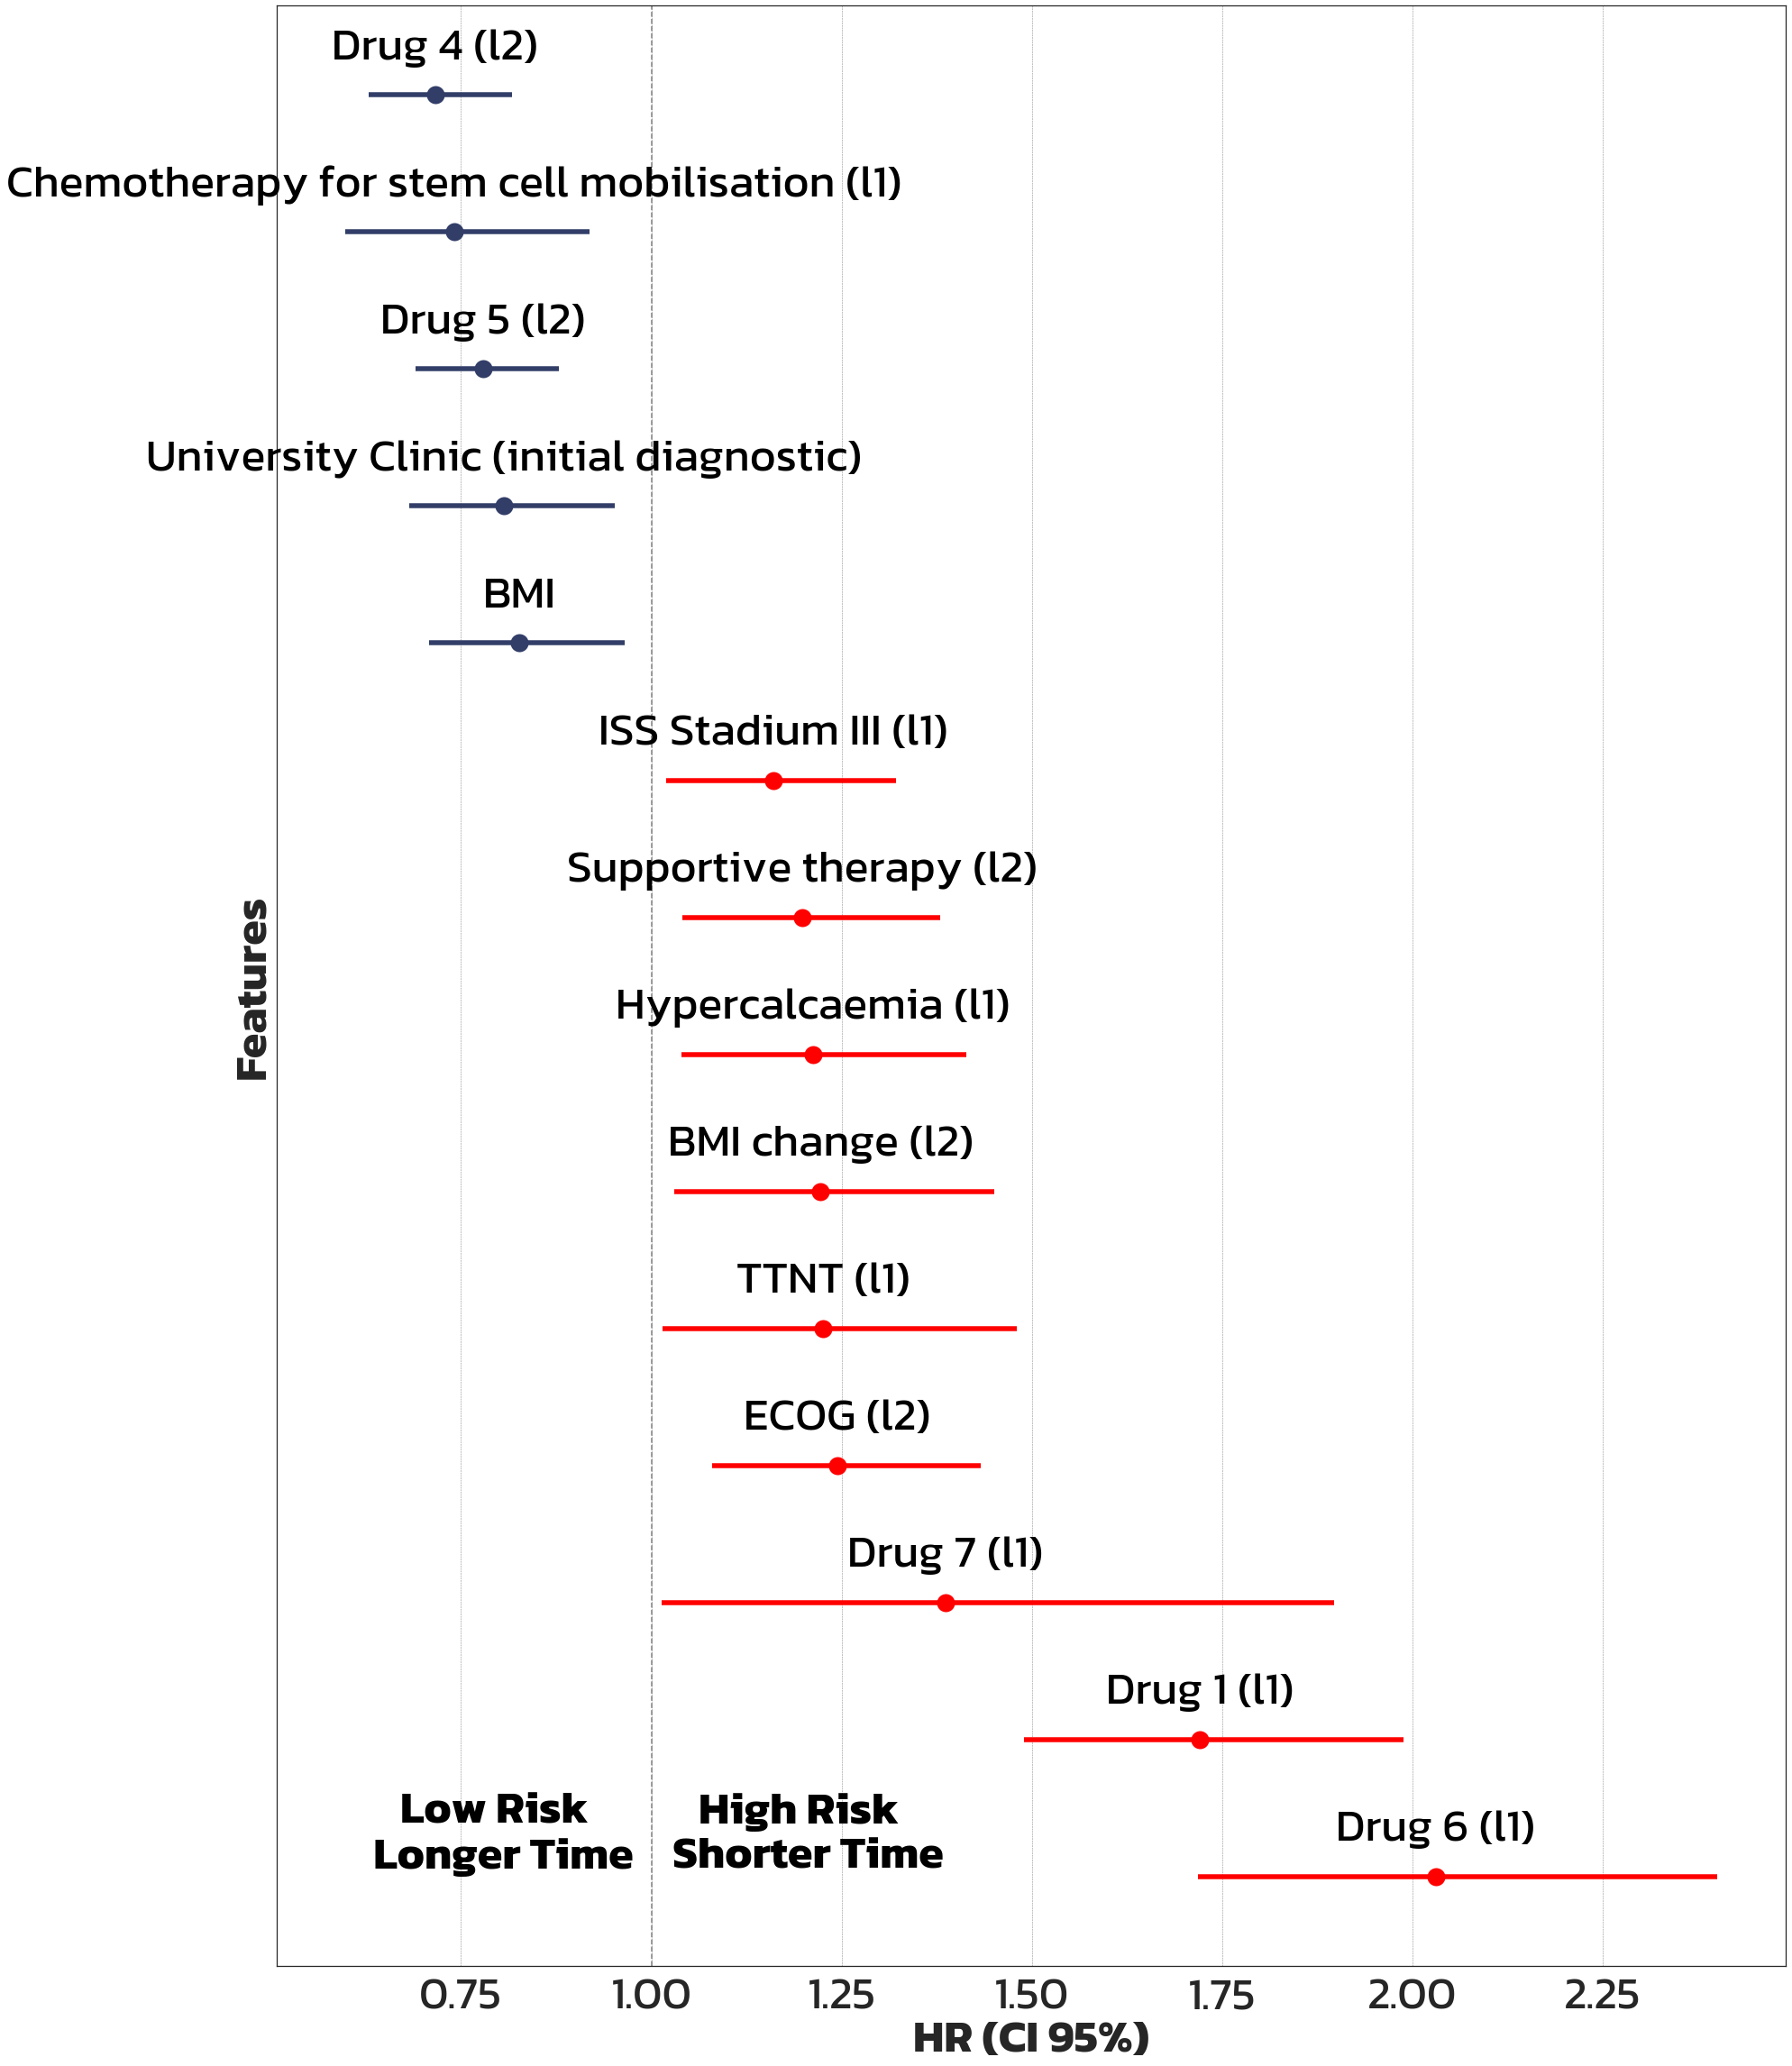

0.6163527110920058 0.617342584690735


In [78]:
if data_frame_type=='training':
    X_train, X_test = preprocess_data(df_02_mapping_drop, threshold_feature_drop=27)

#def cox_feature_importancy(X_train, X_test, clean_feature = True ,data_type = 'training', feature_excluded_from_plot =[],size = (30,40), directory_name='',penalizer=0.0001, l1_ratio=0.9 ):

    top_f_df, score_X_train, score_X_test, cph = cox_feature_importancy(X_train,X_test, clean_feature =True,data_type = data_frame_type, feature_excluded_from_plot =['bin__l2_rtpnotwnierenin','bin__l1_crabkritb','bin__dx_crabkritb','cat__l2_rtptheraentsch_3.0','cat__l2_prottyp_1.0','cat__l1_prottyp_2.0'],size = (30,40), directory_name=directory_name, penalizer=0.001, l1_ratio=0.9)
    print(score_X_train, score_X_test)

elif data_frame_type=='test':
    df_test = preprocess_test_data(df_02_mapping_drop)
    top_f_df, score_X_train, score_X_test, cph = cox_feature_importancy(_,df_test, clean_feature =True,data_type = data_frame_type,feature_excluded_from_plot =['bin__l2_rtpnotwnierenin','bin__l1_crabkritb','bin__dx_crabkritb','cat__l2_rtptheraentsch_3.0','cat__l2_prottyp_1.0','cat__l1_prottyp_2.0'],size = (50,50), directory_name=directory_name, penalizer=0.001, l1_ratio=0.9)
   

### 3.2 C-index Evaluation

The Concordance index (C-index) is a measure used to evaluate the predictive accuracy of survival models. It assesses the model's ability to correctly rank pairs of subjects based on their predicted survival times. The C-index is calculated for both the training and test datasets, with specific considerations for each:

- **Training Dataset:**
  - **Train Set:** Calculate the C-index on the training portion of the dataset to evaluate the model's fit and its ability to predict outcomes on data it has already seen.
  - **Test Set:** Calculate the C-index on the test portion of the training dataset to assess the model's generalizability and its predictive accuracy on unseen data.  
  

- **Test Dataset:**
  - **Test:** For the external or separate test dataset, calculate the C-index to further validate the model's predictive performance on new, unseen data. This step is crucial for understanding how the model performs in real-world scenarios or when applied to data from different sources or time periods.

The C-index values obtained from these evaluations provide insights into the model's predictive accuracy and generalizability, guiding improvements and adjustments to enhance performance.



In [79]:
score_X_train, score_X_test

(0.6163527110920058, 0.617342584690735)

### 3.3 Results of another cox model without Lasso less significant features clean up method 

Just to control the difference in score and effectivness of Lasso less significant features clean up method 

In [80]:
if data_frame_type=='training':
    score_X_train2,score_X_test2 = cox_model(X_train,X_test,data_type = data_frame_type, penalizer=0.001, l1_ratio=0.7)
elif data_frame_type=='test':
    score_X_train2,score_X_test2 = cox_model(_,df_test,data_type = data_frame_type, penalizer=0.001, l1_ratio=0.7)

In [81]:
score_X_train2, score_X_test2

(0.6170665342472987, 0.6141219249749545)

### 3.4 Kaplan-Meier Plot

The Kaplan-Meier plot is a non-parametric statistic used to estimate the survival function from lifetime data. To customize the Kaplan-Meier plot based on specific features, follow the steps below:

1. **Choose Features to be Shown on Plot:**
   - Identify and select the features you wish to visualize in the Kaplan-Meier plot. Group these features into a list named `feature_groups_specific`. This allows for a focused analysis on the impact of these specific features on survival.
   
2. **Plot Name:**
   - Assign a meaningful name to your plot for easy identification. Store this name in a variable called `plot_name`. This name will be used as the title of the Kaplan-Meier plot or for reference purposes in your analysis.




In [82]:
if data_frame_type=='test':
    X_train=df_test

20.961538461538463
[]
bin__l2_drug_5: 443.0
bin__l1_drug_6: 365.0
bin__l2_drug_4: 462.0


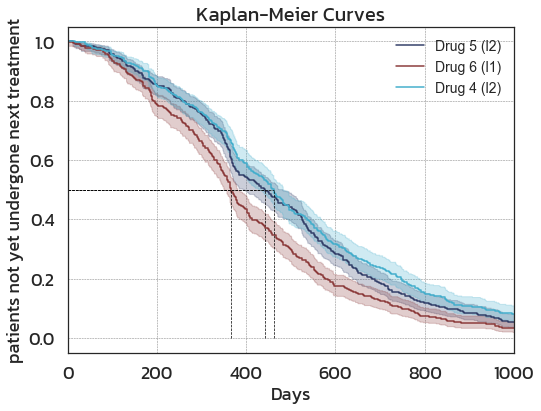

In [83]:
#Kaplan_Meier_plot(X_train,lim_min_percent=10,feature_groups_specific=[], plot_name='', directory_name=''):
Kaplan_Meier_plot(X_train,lim_min_percent=10,feature_groups_specific = ['bin__l2_drug_5','bin__l1_drug_6','bin__l2_drug_4'],plot_name='Drugs', directory_name=directory_name)

13.60576923076923
[]
cat__dx_einrid_1.0: 474.0
cat__dx_einrid_3.0: 354.0


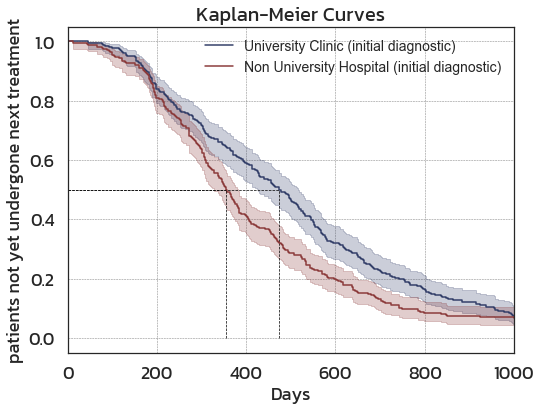

In [84]:

Kaplan_Meier_plot(X_train,lim_min_percent=10,feature_groups_specific = ['cat__dx_einrid_1.0','cat__dx_einrid_3.0'],plot_name='Clinic', directory_name=directory_name)